# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


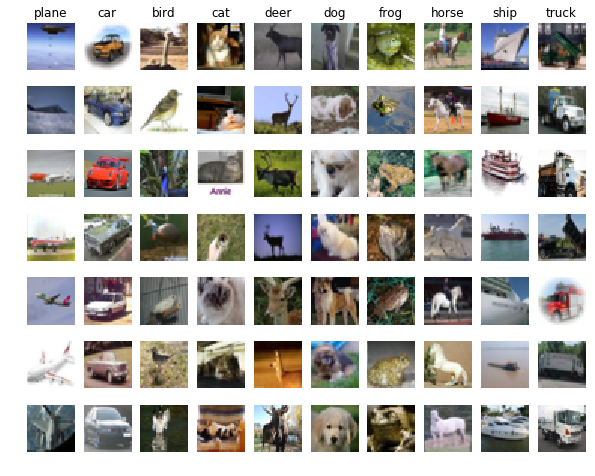

In [2]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [19]:
# Use the validation set to tune the learning rate and regularization strength. You can 
# reuse the softmax_hyperparameter_tuning that you implemented in
# exercise_code.classifiers.softmax

from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax = None

################################################################################
# TODO: Train a softmax classifier on the features and tune hyperparameters to #
# obtain a strong model. You can alter and reuse the                           #
# softmax_hyperparameter_tuning function. Store your best network in the       #
# best_softmax variable.                                                       #
################################################################################
best_softmax, _, _ = softmax_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 15000: loss 2.377143
iteration 100 / 15000: loss 2.375829
iteration 200 / 15000: loss 2.373038
iteration 300 / 15000: loss 2.372211
iteration 400 / 15000: loss 2.370824
iteration 500 / 15000: loss 2.368458
iteration 600 / 15000: loss 2.367773
iteration 700 / 15000: loss 2.365151
iteration 800 / 15000: loss 2.365554
iteration 900 / 15000: loss 2.364174
iteration 1000 / 15000: loss 2.361996
iteration 1100 / 15000: loss 2.360044
iteration 1200 / 15000: loss 2.360886
iteration 1300 / 15000: loss 2.358332
iteration 1400 / 15000: loss 2.357269
iteration 1500 / 15000: loss 2.356226
iteration 1600 / 15000: loss 2.354281
iteration 1700 / 15000: loss 2.354002
iteration 1800 / 15000: loss 2.354138
iteration 1900 / 15000: loss 2.351659
iteration 2000 / 15000: loss 2.350706
iteration 2100 / 15000: loss 2.349843
iteration 2200 / 15000: loss 2.348257
iteration 2300 / 15000: loss 2.347115
iteration 2400 / 15000: loss 2.346784
iteration 2500 / 15000: loss 2.346072
iteration 2600 / 15000: 

In [20]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.336


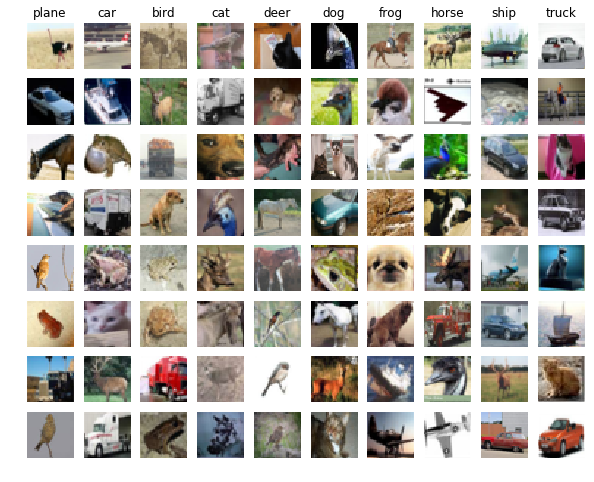

In [21]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [66]:
from exercise_code.classifiers.neural_net import TwoLayerNet, neuralnetwork_hyperparameter_tuning

input_dim = X_train_feats.shape[1]
hidden_dim = 620
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best         #
# model in the best_net variable.                                              #
################################################################################
best_net = neuralnetwork_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val, input_dim, hidden_dim)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 16000: loss 2.303294, acc: 0.079000
iteration 100 / 16000: loss 2.257368, acc: 0.317000
iteration 200 / 16000: loss 1.985843, acc: 0.323000
iteration 300 / 16000: loss 1.733425, acc: 0.397000
iteration 400 / 16000: loss 1.568510, acc: 0.448000
iteration 500 / 16000: loss 1.507603, acc: 0.474000
iteration 600 / 16000: loss 1.463211, acc: 0.496000
iteration 700 / 16000: loss 1.440000, acc: 0.504000
iteration 800 / 16000: loss 1.326652, acc: 0.515000
iteration 900 / 16000: loss 1.297150, acc: 0.523000
iteration 1000 / 16000: loss 1.470208, acc: 0.519000
iteration 1100 / 16000: loss 1.240373, acc: 0.514000
iteration 1200 / 16000: loss 1.450287, acc: 0.528000
iteration 1300 / 16000: loss 1.349555, acc: 0.525000
iteration 1400 / 16000: loss 1.357206, acc: 0.530000
iteration 1500 / 16000: loss 1.335534, acc: 0.537000
iteration 1600 / 16000: loss 1.371566, acc: 0.527000
iteration 1700 / 16000: loss 1.239971, acc: 0.537000
iteration 1800 / 16000: loss 1.320821, acc: 0.538000
itera

iteration 15400 / 16000: loss 0.880044, acc: 0.611000
iteration 15500 / 16000: loss 0.978341, acc: 0.611000
iteration 15600 / 16000: loss 0.947741, acc: 0.617000
iteration 15700 / 16000: loss 0.994530, acc: 0.618000
iteration 15800 / 16000: loss 0.963594, acc: 0.621000
iteration 15900 / 16000: loss 1.044000, acc: 0.622000
0.619
iteration 0 / 16000: loss 2.303931, acc: 0.095000
iteration 100 / 16000: loss 2.230888, acc: 0.313000
iteration 200 / 16000: loss 1.912525, acc: 0.328000
iteration 300 / 16000: loss 1.714683, acc: 0.422000
iteration 400 / 16000: loss 1.463598, acc: 0.462000
iteration 500 / 16000: loss 1.526692, acc: 0.487000
iteration 600 / 16000: loss 1.373861, acc: 0.496000
iteration 700 / 16000: loss 1.424046, acc: 0.516000
iteration 800 / 16000: loss 1.362962, acc: 0.515000
iteration 900 / 16000: loss 1.285807, acc: 0.520000
iteration 1000 / 16000: loss 1.421538, acc: 0.519000
iteration 1100 / 16000: loss 1.284600, acc: 0.529000
iteration 1200 / 16000: loss 1.306049, acc: 0.

iteration 14800 / 16000: loss 1.080785, acc: 0.616000
iteration 14900 / 16000: loss 0.935434, acc: 0.618000
iteration 15000 / 16000: loss 0.986370, acc: 0.616000
iteration 15100 / 16000: loss 1.068775, acc: 0.613000
iteration 15200 / 16000: loss 0.924829, acc: 0.613000
iteration 15300 / 16000: loss 0.862132, acc: 0.619000
iteration 15400 / 16000: loss 0.971244, acc: 0.614000
iteration 15500 / 16000: loss 1.013793, acc: 0.617000
iteration 15600 / 16000: loss 1.003192, acc: 0.619000
iteration 15700 / 16000: loss 0.881475, acc: 0.616000
iteration 15800 / 16000: loss 0.901223, acc: 0.624000
iteration 15900 / 16000: loss 0.918884, acc: 0.619000
0.621
iteration 0 / 16000: loss 2.304819, acc: 0.088000
iteration 100 / 16000: loss 2.257629, acc: 0.321000
iteration 200 / 16000: loss 2.022572, acc: 0.308000
iteration 300 / 16000: loss 1.748714, acc: 0.405000
iteration 400 / 16000: loss 1.616982, acc: 0.440000
iteration 500 / 16000: loss 1.526590, acc: 0.478000
iteration 600 / 16000: loss 1.520576

iteration 14200 / 16000: loss 1.105639, acc: 0.605000
iteration 14300 / 16000: loss 1.132554, acc: 0.602000
iteration 14400 / 16000: loss 1.156702, acc: 0.601000
iteration 14500 / 16000: loss 0.963286, acc: 0.601000
iteration 14600 / 16000: loss 1.056694, acc: 0.601000
iteration 14700 / 16000: loss 0.980408, acc: 0.604000
iteration 14800 / 16000: loss 0.985981, acc: 0.600000
iteration 14900 / 16000: loss 1.096883, acc: 0.607000
iteration 15000 / 16000: loss 1.123737, acc: 0.603000
iteration 15100 / 16000: loss 1.169568, acc: 0.604000
iteration 15200 / 16000: loss 1.078283, acc: 0.605000
iteration 15300 / 16000: loss 1.137812, acc: 0.605000
iteration 15400 / 16000: loss 1.220622, acc: 0.601000
iteration 15500 / 16000: loss 1.063593, acc: 0.602000
iteration 15600 / 16000: loss 1.036921, acc: 0.604000
iteration 15700 / 16000: loss 1.089303, acc: 0.602000
iteration 15800 / 16000: loss 1.151442, acc: 0.610000
iteration 15900 / 16000: loss 1.021440, acc: 0.606000
iteration 0 / 16000: loss 2.

iteration 13600 / 16000: loss 1.096940, acc: 0.605000
iteration 13700 / 16000: loss 1.080309, acc: 0.599000
iteration 13800 / 16000: loss 1.050086, acc: 0.603000
iteration 13900 / 16000: loss 1.170141, acc: 0.600000
iteration 14000 / 16000: loss 1.047733, acc: 0.603000
iteration 14100 / 16000: loss 1.040091, acc: 0.601000
iteration 14200 / 16000: loss 1.086083, acc: 0.601000
iteration 14300 / 16000: loss 1.169005, acc: 0.605000
iteration 14400 / 16000: loss 1.034185, acc: 0.603000
iteration 14500 / 16000: loss 1.102030, acc: 0.602000
iteration 14600 / 16000: loss 1.064502, acc: 0.607000
iteration 14700 / 16000: loss 1.165009, acc: 0.604000
iteration 14800 / 16000: loss 1.135146, acc: 0.605000
iteration 14900 / 16000: loss 1.039853, acc: 0.602000
iteration 15000 / 16000: loss 1.101818, acc: 0.602000
iteration 15100 / 16000: loss 1.064673, acc: 0.609000
iteration 15200 / 16000: loss 1.168688, acc: 0.608000
iteration 15300 / 16000: loss 1.048918, acc: 0.608000
iteration 15400 / 16000: los

iteration 13000 / 16000: loss 0.929212, acc: 0.595000
iteration 13100 / 16000: loss 1.100999, acc: 0.597000
iteration 13200 / 16000: loss 1.087439, acc: 0.600000
iteration 13300 / 16000: loss 0.919365, acc: 0.603000
iteration 13400 / 16000: loss 0.946018, acc: 0.605000
iteration 13500 / 16000: loss 1.009819, acc: 0.599000
iteration 13600 / 16000: loss 1.123524, acc: 0.602000
iteration 13700 / 16000: loss 1.136076, acc: 0.601000
iteration 13800 / 16000: loss 1.133252, acc: 0.607000
iteration 13900 / 16000: loss 0.946687, acc: 0.598000
iteration 14000 / 16000: loss 1.145162, acc: 0.600000
iteration 14100 / 16000: loss 1.064447, acc: 0.597000
iteration 14200 / 16000: loss 0.950519, acc: 0.603000
iteration 14300 / 16000: loss 1.121206, acc: 0.602000
iteration 14400 / 16000: loss 0.978035, acc: 0.598000
iteration 14500 / 16000: loss 1.103539, acc: 0.604000
iteration 14600 / 16000: loss 1.101107, acc: 0.607000
iteration 14700 / 16000: loss 1.037706, acc: 0.605000
iteration 14800 / 16000: los

iteration 12400 / 16000: loss 1.155364, acc: 0.601000
iteration 12500 / 16000: loss 0.983132, acc: 0.607000
iteration 12600 / 16000: loss 0.999796, acc: 0.612000
iteration 12700 / 16000: loss 1.082100, acc: 0.605000
iteration 12800 / 16000: loss 1.123555, acc: 0.606000
iteration 12900 / 16000: loss 1.025178, acc: 0.601000
iteration 13000 / 16000: loss 1.105434, acc: 0.606000
iteration 13100 / 16000: loss 1.043243, acc: 0.612000
iteration 13200 / 16000: loss 1.027306, acc: 0.610000
iteration 13300 / 16000: loss 1.011806, acc: 0.609000
iteration 13400 / 16000: loss 1.056933, acc: 0.607000
iteration 13500 / 16000: loss 0.994630, acc: 0.603000
iteration 13600 / 16000: loss 1.112234, acc: 0.604000
iteration 13700 / 16000: loss 0.977257, acc: 0.608000
iteration 13800 / 16000: loss 0.996069, acc: 0.608000
iteration 13900 / 16000: loss 1.087874, acc: 0.604000
iteration 14000 / 16000: loss 1.069721, acc: 0.608000
iteration 14100 / 16000: loss 0.973456, acc: 0.609000
iteration 14200 / 16000: los

iteration 11800 / 16000: loss 1.174821, acc: 0.591000
iteration 11900 / 16000: loss 1.078922, acc: 0.592000
iteration 12000 / 16000: loss 1.132852, acc: 0.595000
iteration 12100 / 16000: loss 1.154702, acc: 0.595000
iteration 12200 / 16000: loss 1.202421, acc: 0.599000
iteration 12300 / 16000: loss 1.142627, acc: 0.593000
iteration 12400 / 16000: loss 1.082629, acc: 0.598000
iteration 12500 / 16000: loss 1.242542, acc: 0.598000
iteration 12600 / 16000: loss 1.046924, acc: 0.593000
iteration 12700 / 16000: loss 1.153282, acc: 0.598000
iteration 12800 / 16000: loss 1.172782, acc: 0.591000
iteration 12900 / 16000: loss 1.090670, acc: 0.597000
iteration 13000 / 16000: loss 1.095249, acc: 0.595000
iteration 13100 / 16000: loss 1.026224, acc: 0.597000
iteration 13200 / 16000: loss 1.198702, acc: 0.599000
iteration 13300 / 16000: loss 1.180453, acc: 0.595000
iteration 13400 / 16000: loss 1.193079, acc: 0.597000
iteration 13500 / 16000: loss 1.219725, acc: 0.597000
iteration 13600 / 16000: los

iteration 11200 / 16000: loss 1.204509, acc: 0.591000
iteration 11300 / 16000: loss 1.174157, acc: 0.594000
iteration 11400 / 16000: loss 1.203552, acc: 0.594000
iteration 11500 / 16000: loss 1.061101, acc: 0.595000
iteration 11600 / 16000: loss 1.193970, acc: 0.598000
iteration 11700 / 16000: loss 1.114276, acc: 0.600000
iteration 11800 / 16000: loss 1.065971, acc: 0.592000
iteration 11900 / 16000: loss 1.147690, acc: 0.603000
iteration 12000 / 16000: loss 1.120472, acc: 0.596000
iteration 12100 / 16000: loss 1.348581, acc: 0.599000
iteration 12200 / 16000: loss 1.173517, acc: 0.596000
iteration 12300 / 16000: loss 1.088481, acc: 0.592000
iteration 12400 / 16000: loss 1.208029, acc: 0.589000
iteration 12500 / 16000: loss 1.204648, acc: 0.592000
iteration 12600 / 16000: loss 1.021918, acc: 0.592000
iteration 12700 / 16000: loss 1.249435, acc: 0.595000
iteration 12800 / 16000: loss 1.031161, acc: 0.598000
iteration 12900 / 16000: loss 1.097418, acc: 0.599000
iteration 13000 / 16000: los

In [67]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.628


## Save the model

When you are satisfied with your training, save the model for submission. In order to pass this exercise, you have to score more than __55__ points.

In [68]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)